#  Lunar Lander with SARSA($\lambda$) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is SARSA($\lambda$) as discussed in [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

## Import libraries

In [1]:
try:
    import google.colab
    from IPython.display import clear_output
    !apt-get install swig
    !pip install swig
    !pip install gymnasium[box2d]
    !pip install moviepy==2.2.1
    clear_output(wait=True)
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union, Callable
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [3]:
ENV_NAME = 'LunarLander-v3'

In [4]:
env = gym.make(ENV_NAME)
SLOW = env.observation_space.low
SHIGH = env.observation_space.high
SRANGE = SHIGH - SLOW
cardS = len( env.observation_space.low )
A = np.arange( env.action_space.n )
cardA = len(A)
env.close()
num_best_policies = 10

### Hyperparameters

In [5]:
γ = 0.999
λ = 0.1
Δ = 1e-6
lr = (0.1, 0.1)

## Functions

### Helper Functions

In [6]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], 
                       ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

In [7]:
def record_policy( w:NDArray[np.float32], 
                   φ:Callable[[NDArray[np.float32], int],int],
                   title:str, 
                   M:int = 10, 
                   seed:int = 2025,
                   enable_wind = False ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array", enable_wind=enable_wind)
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + m * 3e4 ) )
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

In [8]:
def plot_value_heatmap( w, φ, num_samples = 100, bins = 100 ):
    
    pos_x_list = []
    pos_y_list = []
    V_list_env = []
    V_list_policy = []

    env = gym.make(ENV_NAME)    
    
    for _ in range(num_samples):

        state, _ = env.reset()
        terminated = False
        truncated = False
    
        while not( terminated or truncated ):
            a = env.action_space.sample()
            sP, r, terminated, truncated, _ = env.step( a )        
            pos_x, pos_y, *_ = state
            state = sP
            V_s = np.mean( [np.dot( φ( state, a ), w ) for a in A ] )
            
            pos_x_list.append(pos_x)
            pos_y_list.append(pos_y)
            V_list_env.append(r)
            V_list_policy.append(V_s)

    env.close()

    cmap = LinearSegmentedColormap.from_list( 'custom_cmap', 
                                             [ (0.0, 'red'),    # Negative
                                               (0.5, 'black'),  # Zero
                                               (1.0, 'green')   # Positive
                                             ])
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    norm_env = TwoSlopeNorm(vmin=min(V_list_env), vcenter=0, vmax=max(V_list_env))
    norm_policy = TwoSlopeNorm(vmin=min(V_list_policy), vcenter=np.median(V_list_policy), vmax=max(V_list_policy))

    # First heatmap (hist2d)
    im_env = axes[0].hist2d( pos_x_list, pos_y_list, bins=bins, weights=V_list_env, cmap=cmap, norm=norm_env )
    axes[0].set_title('Environment Reward')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im_env[3], ax=axes[0], label='R')

    # Second heatmap
    im_policy = axes[1].hist2d(  pos_x_list, pos_y_list, bins=bins, weights=V_list_policy, cmap=cmap, norm=norm_policy )
    axes[1].set_title('Expected Value')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im_policy[3], ax=axes[1], label='$V(s)$')

    plt.tight_layout()
    plt.show()

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [9]:
def π( state:NDArray[np.float32], 
       w:NDArray[np.float32], 
       φ:Callable[[NDArray[np.float32], int], int] ) -> int:
    
    return( np.argmax([np.dot( φ(state, a), w ) for a in A]) )

### TD Learning rate/step size

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [10]:
def α( n:int ) -> float:
    α_init, α_decay = lr
    return( max( α_init / (n + 1)**α_decay, Δ ) )

### Evaluate policy

In [11]:
def evaluate_policy( w:NDArray[np.float32], 
                     φ:Callable[[NDArray[np.float32], int], int], 
                     num_evaluations:int = 10,
                     seed:int = 42,
                     enable_wind:bool = False ) -> Tuple[np.float32, np.float32]:
    
    env = gym.make(ENV_NAME, enable_wind=enable_wind)
    
    G = []

    for n in np.arange(num_evaluations):
        terminated = False
        truncated = False
        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated,_ = env.step(a)
            s = sP
            Gm += r

        G.append(Gm)

    env.close()
    mean, hw = calculate_mean_hw(G)
    return( mean, hw )


### **SARSA**($\lambda$)

Algorithm taken from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

<b>Inputs</b>:
- $\pi$: Policy whose value function is sought
-  function $\hat{v}:S \times \mathbb{R}^d \rightarrow \mathbb{R}$

<b>Parameters</b>
- step size $\alpha > 0$, trace decay rate $\lambda \in [0,1]$

<b>algorithm</b>:<br>
01: Initialize value-function weights $\mathbf{w}$ (e.g. $\mathbf{w} = 0$)<br>
02: Loop for each episode:<br>
03: &nbsp;&nbsp;&nbsp;&nbsp;Initailize $S$<br>
04: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \mathbf{0}$<br>
05: &nbsp;&nbsp;&nbsp;&nbsp;Loop for each step of episode:<br>
06: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $A \sim \pi(\cdot | S)$<br>
07: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Take action $A$, observe $R, S'$<br>
08: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \gamma \lambda \mathbf{z} + \nabla\hat{v}(S,\mathbf{w})$<br>
09: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta \gets R + \gamma \hat{v}(S',\mathbf{w}) - \hat{v}(S,\mathbf{w})$<br>
10: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{w} \gets \mathbf{w} + \alpha \delta \mathbf{z}$<br>
11: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \gets S'$<br>
12: &nbsp;&nbsp;&nbsp;&nbsp;Until $S'$ is terminal


In [12]:
def SARSAλ( w:NDArray[np.float32], 
                φ:Callable[ [NDArray[np.float32], int], int ], 
                M:int = 500, 
                seed:int = 1982, 
                enable_wind:bool=False ) -> NDArray[np.float32]:

    env = gym.make(ENV_NAME, enable_wind=enable_wind)

    d = []
    
    wP = w

    for m in tqdm( np.arange(M) ):

        z = np.zeros_like( w )

        terminated = False
        truncated = False
        s,_ = env.reset(seed=int(m * 1e5 + seed * 2e3))
        np.random.seed(seed=int(m * 1e5 + seed * 2e3) )
        

        while not(terminated or truncated):
            
            a = π( s, w, φ )
                
            sP, r, terminated, truncated, _ = env.step(a)
            
            aP = π( sP, w, φ )

            gradV = φ( s, a ) 
            V = np.dot( w, φ( s, a ) )
            Vp = np.dot( w, φ( sP, aP ) ) * ( 1 - terminated )

            z = γ * λ * z + gradV
            
            δ = (r + γ * Vp - V)
            
            wP = wP + α(m) * δ * z 
            
            s = sP
            a = aP
            
        w = wP

        μ, δ = evaluate_policy( w, φ, seed=seed, enable_wind=enable_wind, num_evaluations=10 )
        score = μ - δ 
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})
        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} ± {δ:3.2f})")

    env.close()

    policies = pd.DataFrame( d )

    return( policies )


## Run **SARSA**($\lambda$)

### Feature vectors

In [13]:
def simple(state, action):
    x = np.hstack( ( state ) )
    fv = np.hstack([x * (action == a) for a in A ])
    return( fv )

In [14]:
def interactions(state,action):

    px, py, vx, vy, θ, ω, lf, rf = state

    interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                             py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                             vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                             vy*θ, vy*ω, vy*lf, vy*rf,
                             θ*ω, θ*lf, θ*rf,
                             θ*lf, θ*rf,
                             lf*rf])

    x = np.hstack( ( state, interactions ))
    fv = np.hstack([x * (action == a) for a in A ])
    return( fv )

In [ ]:
f = interactions
seed = 1982
k = len( f( np.zeros(cardS), 0 ) )
w = np.zeros( k )
policies = SARSAλ( w, M=500, φ=f, seed=seed, enable_wind=False )

### Plot learning curve

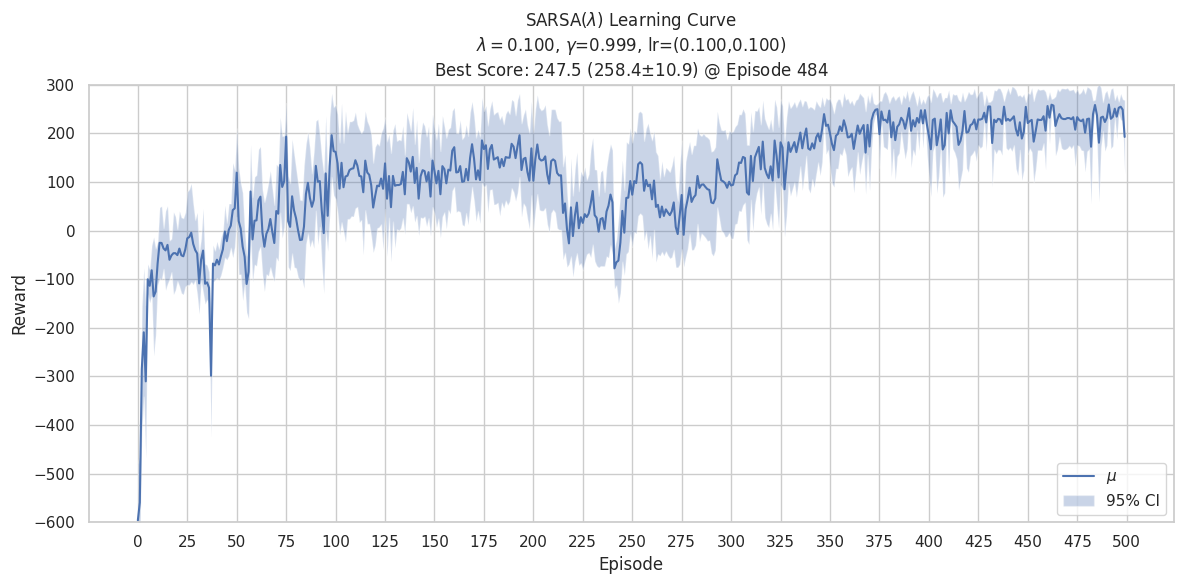

In [16]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"SARSA($\\lambda$) Learning Curve\n" +\
          f"$\\lambda={λ:.3f}$, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [17]:
best_score = -np.inf
print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], f, num_evaluations=30, seed=1982, enable_wind=False)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode 484	189.2	(221.0 ± 31.8)
Episode 462	161.1	(202.1 ± 41.0)
Episode 491	173.6	(211.5 ± 37.8)
Episode 430	196.2	(224.2 ± 28.0)
Episode 431	175.2	(210.4 ± 35.2)
Episode 449	189.6	(221.3 ± 31.7)
Episode 438	166.0	(204.8 ± 38.9)
Episode 460	196.4	(227.5 ± 31.1)
Episode 463	169.6	(207.5 ± 37.9)
Episode 496	187.0	(219.0 ± 32.0)
SUPERLATIVE POLICY:	EPISODE 460


### The superlative policy $w^*$ weights

In [18]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[-3.43e+00  4.83e+01  2.01e+01  3.81e+01]
 [-2.39e+01 -1.66e+00  7.00e+01  5.54e+01]
 [-2.48e+01 -6.11e+01  1.17e+01  1.19e+01]
 [ 5.66e+01  2.91e+01 -8.02e+00 -4.36e+01]
 [ 2.18e+00 -3.97e+00  3.94e+00  1.40e+00]
 [-3.23e+01  3.11e+01  2.82e+01 -2.14e+00]
 [-2.79e+00  1.08e+00  2.60e+01  1.21e+02]
 [ 1.11e+02 -1.39e+02  6.28e+00  1.43e+01]
 [ 6.28e+00  1.43e+01 -1.53e+01  8.82e+01]
 [ 3.78e+01  1.81e+01  3.98e+01 -9.59e+01]
 [-3.29e+00 -4.84e+01 -5.44e+01  3.55e+01]
 [-3.74e+01  4.45e+01  3.67e+01  8.39e-02]
 [-1.45e+01  5.81e+00 -5.78e+01 -4.60e+01]
 [-4.65e+01  7.90e-01  5.12e-02 -5.64e+00]
 [ 8.07e+01  7.72e+00  1.92e+01 -3.41e+01]
 [ 1.56e+02  6.18e+01  4.06e+01  6.18e+01]
 [-1.64e+02  2.62e+00  1.34e+01  2.62e+00]
 [ 1.34e+01 -1.03e+01  2.05e+01 -1.42e+02]
 [-1.32e+01 -1.31e+02  5.20e+01  4.73e+00]
 [-5.49e+01 -3.50e+01  1.47e+01 -2.39e+02]
 [ 1.06e+02  1.40e+01  1.43e+01  3.63e+00]
 [-1.82e+01 -1.59e+02  4.59e+01  2.53e+01]
 [-1.31e+00  2.44e+00 -3.77e+01  2.53e+02]
 [ 1.30

### View video recording of the best policy

In [ ]:
title = f"SARSA, LAMBA={λ:0.3f}, GAMMA={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, f, title, enable_wind=False, seed=1982 )
print(f"Done! Video saved to {video_filename}")

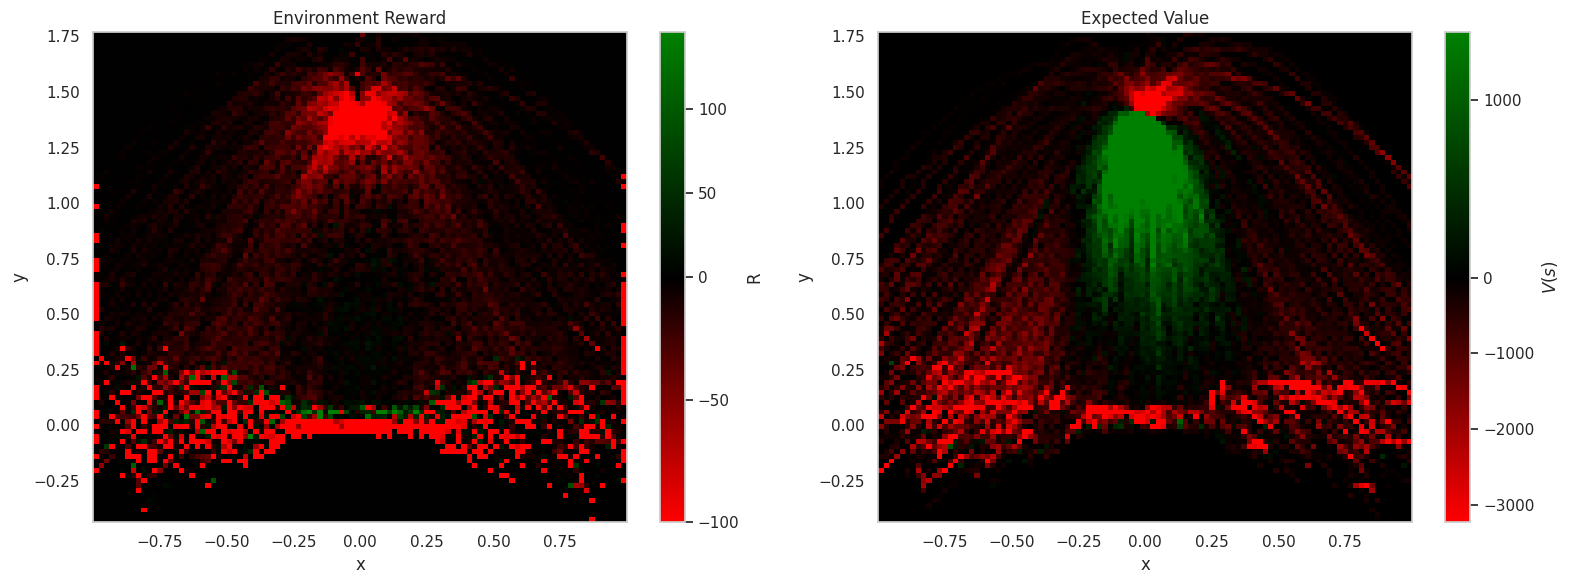

In [22]:
plot_value_heatmap( w_star, interactions, int(1000) )
Video(video_filename, embed=True)